# Supervised Learning Method Outline

---



## Data Preprocessing

### 1. Loading Data
- Load the MIMIC-IV dataset (hosp, icu, notes).

### 2. Feature Selection
- Select relevant features based on the defined digital phenotype.

### 3. Data Cleaning
- Remove outliers, handle missing data, and other noise.

### 4. Data Normalisation
- Standardise the scales for numerical features.
- Impute missing values particularly for important features

### 5. Label Encoding/Categorisation
- Convert categorical features to numerical values if needed.

### 6. Natural Language Processing (NLP)
- Extract and categorise insights from clinical notes.

### 7. Balance Datasets
- Handle significant class imbalance using Upsampling/Downsampling techniques
- E.g. SMOTE, class_weight

### 8. Train-Test Split
- Partition the dataset into training and testing sets.
- Stratify datasets

---

## Model Building

### 1. Model Selection
- Choose appropriate machine learning model(s) (e.g., Decision Trees, Random Forest, SVM).

### 2. Hyperparameter Tuning
- Fine-tune model hyperparameters using techniques like GridSearch or RandomSearch.

### 3. Feature Importance
- Evaluate and rank the importance of each feature.

### 4. Model Training
- Train the selected model on the training dataset.

---

## Model Evaluation

### 1. Validation Metrics
- Define metrics for evaluation (e.g., accuracy, precision, recall, F1-score).

### 2. Cross-Validation
- Apply cross-validation to assess model performance.

### 3. Performance Metrics
- Compute performance metrics on the testing set.

### 4. Confusion Matrix
- Generate a confusion matrix to evaluate class-wise performance.

### 5. ROC Curve
- Evaluate the Receiver Operating Characteristic (ROC) curve.

---


# Model Imports

In [2]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
# from google.colab import auth
# from google.cloud import bigquery

# # authenticate
# auth.authenticate_user()

# User options: 'Will', 'Chinatip'
# USER = "Will"
USER = "Will"

# Set up environment variables
if USER == 'Will':
    project_id = 'eighth-arbor-396212'
elif USER == 'Chinatip':
    project_id = 'ml-health-application'
else:
    project_id = None # FILL IN HERE

os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'


## Select All Patient Features

In [3]:
BIG_QUERY = False

if BIG_QUERY:
    query = "SELECT * FROM `comp90089-hai-patients.hai_patients.patient_cohort_features` limit 3000"
    data = run_query(query)
else:
    # from google.colab import drive
    # drive.mount('/content/drive')

    file_path = ''
    if USER == 'Will':
        file_path = '/content/drive/My Drive/Colab Notebooks/COMP90089 Group Project Data/patient_cohort_features_vap.csv'
        file_path = 'patient_cohort_features_vap.csv'
    data = pd.read_csv(file_path)


# Data Cleaning

In [4]:
def check_null():
  #Check missing values
  print(data.isnull().sum(),"\n\n")

  #Check the type of data for each column. Notice that 'gender' is categorical (object) and 'dod' is time series.
  print(data.info())
check_null()

subject_id                             0
hadm_id                                0
stay_id                                0
duration_from_vap_device            7990
type__s__cmv                        7990
                                    ... 
vent_o2_device-high_flow_neb        7215
vent_o2_device-nasal_cannula        7215
vent_o2_device-t-piece              7215
vent_o2_device-trach_mask_          7215
vent_o2_device-tracheostomy_tube    7215
Length: 277, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26974 entries, 0 to 26973
Columns: 277 entries, subject_id to vent_o2_device-tracheostomy_tube
dtypes: float64(258), int64(2), object(17)
memory usage: 57.0+ MB
None


## Drop Columns

In [5]:
import pandas as pd
from datetime import datetime

def is_datetime_col(series, sample_size=100):
    """Check if a pandas Series contains datetime-like values."""
    sample = series.dropna().sample(min(sample_size, series.count()))
    for item in sample:
        try:
            # Try to convert to datetime object
            datetime.strptime(str(item), '%Y-%m-%d %H:%M:%S %Z')
        except ValueError:
            return False
    return True

# Assume 'data' is your DataFrame
datetime_cols = []
for col in data.columns:
    if is_datetime_col(data[col]):
        datetime_cols.append(col)

# Drop datetime columns
data = data.drop(columns=datetime_cols)

print(f"Dropped the following datetime columns: {datetime_cols}")

Dropped the following datetime columns: ['abnormal_procalcitonin', 'abnormal_oxygen_levels_from_vap_lab', 'abnormal_wbc_count_from_vap_lab', 'belowavr_wbc_count_from_vap_lab', 'aboveavr_wbc_count_from_vap_lab', 'abnormal_c_reactive_protein_from_vap_lab', 'abnormal_procalcitonin_from_vap_lab', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']


In [6]:
data.drop(['subject_id', 'hadm_id', 'stay_id', 'stay_id_1', 'admit_provider_id'], axis=1, inplace=True)


In [7]:
# #drop records with unknown race and gender
# data = data[data['race'] != 'Unknown']
# data = data[data['gender'] != None]


# # Fill missing value with mean values
# data.fillna(data.mean(), inplace=True)
# data

In [8]:
# Iterate over columns and apply the prefix and fill NaN with replacement value
for col in data.columns:
    if col.startswith("type_"):
        data[col].fillna(0, inplace=True)
check_null()

duration_from_vap_device            7990
type__s__cmv                           0
type_aprv                              0
type_aprv_biphasic_apnpress            0
type_aprv_biphasic_apnvol              0
                                    ... 
vent_o2_device-high_flow_neb        7215
vent_o2_device-nasal_cannula        7215
vent_o2_device-t-piece              7215
vent_o2_device-trach_mask_          7215
vent_o2_device-tracheostomy_tube    7215
Length: 260, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26974 entries, 0 to 26973
Columns: 260 entries, duration_from_vap_device to vent_o2_device-tracheostomy_tube
dtypes: float64(249), object(11)
memory usage: 53.5+ MB
None


In [9]:
# drop na and duplicate records
# data = data.dropna()
data = data.drop_duplicates()

# Remove na records
check_null()

duration_from_vap_device            4816
type__s__cmv                           0
type_aprv                              0
type_aprv_biphasic_apnpress            0
type_aprv_biphasic_apnvol              0
                                    ... 
vent_o2_device-high_flow_neb        4257
vent_o2_device-nasal_cannula        4257
vent_o2_device-t-piece              4257
vent_o2_device-trach_mask_          4257
vent_o2_device-tracheostomy_tube    4257
Length: 260, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
Index: 17860 entries, 0 to 26968
Columns: 260 entries, duration_from_vap_device to vent_o2_device-tracheostomy_tube
dtypes: float64(249), object(11)
memory usage: 35.6+ MB
None


## Data Normalisation & Label Encoding/Categorisation

In [10]:
type_df = data.applymap(type)

string_columns = []
for col in type_df.columns:
    if (type_df[col] == str).any():
        string_columns.append(col)

print(f"Columns with at least one string element: {string_columns}")

Columns with at least one string element: ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'gender', 'anchor_year_group', 'dod', 'HAI_category']


#### Transform DOD Feature

In [11]:
data['died'] = data['dod'].notna()

data.drop('dod', axis=1, inplace=True)

In [12]:
data["HAI_category"].value_counts()

HAI_category
No HAI    13232
HAP        4628
Name: count, dtype: int64

### Filter High NaN Counts

In [13]:
# Count NaN values per column
nan_count = data.isna().sum()

# Calculate percentage of NaN values
nan_percentage = (data.isna().sum() / len(data)) * 100

# Filter columns with more than a certain percentage of NaN values (e.g., 50%)
high_nan_columns = nan_percentage[nan_percentage > 50]

print(f'Columns with > 50% NaN: {len(high_nan_columns)}')

# Drop the columns in place
data.drop(columns=high_nan_columns.index, inplace=True)

Columns with > 50% NaN: 45


In [14]:
data.columns

Index(['duration_from_vap_device', 'type__s__cmv', 'type_aprv',
       'type_aprv_biphasic_apnpress', 'type_aprv_biphasic_apnvol',
       'type_apv__cmv_', 'type_apv__simv_', 'type_asv', 'type_ambient',
       'type_apnea_ventilation',
       ...
       'vent_type-vs', 'vent_o2_device-aerosol-cool',
       'vent_o2_device-endotracheal_tube',
       'vent_o2_device-high_flow_nasal_cannula',
       'vent_o2_device-high_flow_neb', 'vent_o2_device-nasal_cannula',
       'vent_o2_device-t-piece', 'vent_o2_device-trach_mask_',
       'vent_o2_device-tracheostomy_tube', 'died'],
      dtype='object', length=215)

In [15]:
# Convert DataFrame columns to a list
column_list = data.columns.tolist()

# Print the list of columns
print(column_list)

['duration_from_vap_device', 'type__s__cmv', 'type_aprv', 'type_aprv_biphasic_apnpress', 'type_aprv_biphasic_apnvol', 'type_apv__cmv_', 'type_apv__simv_', 'type_asv', 'type_ambient', 'type_apnea_ventilation', 'type_cmv', 'type_cmv_assist', 'type_cmv_assist_autoflow', 'type_cmv_autoflow', 'type_cpap_pps', 'type_cpap_psv', 'type_cpap_psv_apnpres', 'type_cpap_psv_apnvol', 'type_mmv', 'type_mmv_autoflow', 'type_mmv_psv', 'type_mmv_psv_autoflow', 'type_p_cmv', 'type_p_simv', 'type_pcv_', 'type_pcv__psv', 'type_pcv_assist', 'type_pres_ac', 'type_prvc_ac', 'type_prvc_simv', 'type_psv_sbt', 'type_simv', 'type_simv_autoflow', 'type_simv_pres', 'type_simv_psv', 'type_simv_psv_autoflow', 'type_simv_vol', 'type_synchron_master', 'type_synchron_slave', 'type_vol_ac', 'type_vs', 'value_aerosol_cool', 'value_endotracheal_tube', 'value_high_flow_nasal_cannula', 'value_high_flow_neb', 'value_nasal_cannula', 'value_t_piece', 'value_trach_mask_', 'value_tracheostomy_tube', 'admission_type', 'admission_lo

### Label Encoding

In [16]:
y = data['HAI_category']

data.drop('HAI_category', axis=1, inplace=True)

data = pd.get_dummies(data, columns=['admission_type', 'race', 'gender', 'insurance', 'admission_type', 'admission_location', 'discharge_location', 'language', 'marital_status', 'anchor_year_group'])

# Create a LabelEncoder instance
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# fill missing value with mean  
data.fillna(data.median(), inplace=True) # WE SHOULD PERFORM THIS AFTER TRAIN SPLIT TO PREVENT DATA LEAKAGE

### Data Normalisation

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Initialize the MinMaxScaler
scaler = StandardScaler()

X = data.copy()

# Fit and transform the scaler on the DataFrame
X_normalised = scaler.fit_transform(X)

# Create a new DataFrame with the normalized values
X_normalised = pd.DataFrame(X_normalised, columns=X.columns)

# Model Building

### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalised, y, test_size=0.2, random_state=42, stratify=y)

### Feature Selection

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

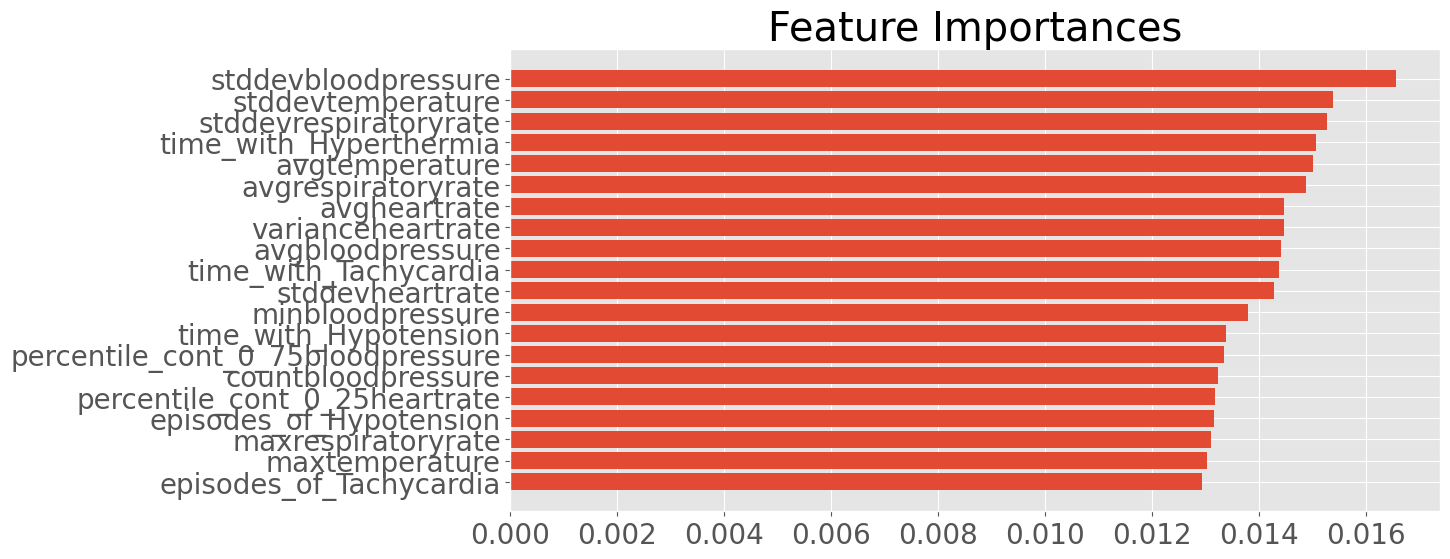

69                          stddevbloodpressure
93                            stddevtemperature
81                        stddevrespiratoryrate
98                       time_with_Hyperthermia
90                               avgtemperature
                         ...                   
249                          insurance_Medicaid
271    admission_location_WALK-IN/SELF REFERRAL
285                                  language_?
82                      variancerespiratoryrate
287                     marital_status_DIVORCED
Name: feature, Length: 150, dtype: object

In [20]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for the importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame by the importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.gca().invert_yaxis()
plt.show()

# You can choose to keep only the most important features based on a certain threshold or top N features
important_features = feature_importances[feature_importances['importance'] > 0.001]['feature']
X_reduced = X[important_features]
important_features

### Model Evaluation

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, recall_score

def evaluate_model(y_pred, y_test, verbose=True):

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    # Compute the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
    # Using recall_score to get recall for Class 0 specifically
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    
    if verbose:
        print(f'Accuracy of the final model: {accuracy:.2f}')

        print(f'Multi-class ROC-AUC score: {roc_auc:.2f}')

        # Print classification report
        print(classification_report(y_test, y_pred))
        
        print(f"Recall for HAP: {recall_class_0:.3f}")
    
    return recall_class_0, accuracy, roc_auc


In [22]:
from sklearn.ensemble import RandomForestClassifier

le = LabelEncoder()

# Fit and transform the labels
y_encoded = le.fit_transform(y)

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y_encoded, test_size=0.2, random_state=42, stratify=y)

## Baseline Model
Accuracy: 0.72
ROC-AUC: 0.65

In [23]:
final_rf = RandomForestClassifier(n_estimators=100, random_state=42)

final_rf.fit(X_train_reduced, y_train)

y_pred = final_rf.predict(X_test_reduced)

evaluate_model(y_pred, y_test)


Accuracy of the final model: 0.74
Multi-class ROC-AUC score: 0.53
              precision    recall  f1-score   support

           0       0.54      0.08      0.14       926
           1       0.75      0.98      0.85      2646

    accuracy                           0.74      3572
   macro avg       0.65      0.53      0.49      3572
weighted avg       0.70      0.74      0.67      3572

Recall for HAP: 0.080


(0.07991360691144708, 0.7441209406494961, 0.5282410060256404)

### SMOTE Model

In [24]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reduced, y_train)

# Fit the model
final_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_smote.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = final_rf_smote.predict(X_test_reduced)

evaluate_model(y_pred, y_test)


Accuracy of the final model: 0.74
Multi-class ROC-AUC score: 0.56
              precision    recall  f1-score   support

           0       0.48      0.19      0.27       926
           1       0.77      0.93      0.84      2646

    accuracy                           0.74      3572
   macro avg       0.62      0.56      0.56      3572
weighted avg       0.69      0.74      0.69      3572

Recall for HAP: 0.191


(0.19114470842332612, 0.7362821948488242, 0.5591022105986623)

### Class Weight Model

In [25]:
# Assign higher weight to class 0
class_weights = {0: 5, 1: 1}

final_rf_weighted = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
final_rf_weighted.fit(X_train_reduced, y_train)

# Evaluate the model
y_pred = final_rf_weighted.predict(X_test_reduced)

evaluate_model(y_pred, y_test)


Accuracy of the final model: 0.74
Multi-class ROC-AUC score: 0.52
              precision    recall  f1-score   support

           0       0.49      0.08      0.13       926
           1       0.75      0.97      0.85      2646

    accuracy                           0.74      3572
   macro avg       0.62      0.52      0.49      3572
weighted avg       0.68      0.74      0.66      3572

Recall for HAP: 0.078


(0.07775377969762419, 0.7402015677491601, 0.5248935187225838)

# Neural Model

### Prepare Input

In [26]:
def label_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    print("Unique values:", unique)
    print("Counts:", counts)


In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

label_counts(y_train)

Unique values: [0 1]
Counts: [ 3702 10586]


### Undersampling

In [28]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the data
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

label_counts(y_train_undersampled)

Unique values: [0 1]
Counts: [3702 3702]


### Oversampling

In [29]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Fit and transform the data
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

label_counts(y_train_oversampled)

Unique values: [0 1]
Counts: [ 5293 10586]


### Hybrid Sampling

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define the under-sampling and over-sampling methods
under = RandomUnderSampler(sampling_strategy={1: 8000})  # Reduce majority class to 8000
over = SMOTE(sampling_strategy={0: 5000})  # Increase minority class to 6000

# Define pipeline
pipeline = Pipeline(steps=[('u', under), ('o', over)])

# Apply the pipeline to the training data
X_train_hybrid_sampled, y_train_hybrid_sampled = pipeline.fit_resample(X_train, y_train)

label_counts(y_train_hybrid_sampled)

Unique values: [0 1]
Counts: [5000 8000]


### Model Hyperparameter Tuning

{'batch_size': 64, 'dropout_rate': 0.2, 'neurons': 64, 'optimizer': 'SGD'}

In [31]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_hyperparameter_model(optimizer='adam', dropout_rate=0.2, neurons=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_hyperparameter_model, 
                        verbose=0, 
                        epochs=10, # Default
                        batch_size=32, # Default
                        optimizer='adam', # Default
                        dropout_rate=0.2, # Default
                        neurons=128)

# Define the grid search parameters
param_grid = {
    'batch_size': [32, 64, 128],
    'optimizer': ['SGD', 'Adam', 'Adagrad'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'neurons': [64, 128, 256]
}

# Create GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)

# # Summarise results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best: 0.747201 using {'batch_size': 64, 'dropout_rate': 0.2, 'neurons': 64, 'optimizer': 'SGD'}")


Best: 0.747201 using {'batch_size': 64, 'dropout_rate': 0.2, 'neurons': 64, 'optimizer': 'SGD'}


### Build and Compile Model

In [32]:
from tensorflow.keras.layers import BatchNormalization

def build_and_compile_model(layer_units=[128, 64], dropout_rates=[0.2, 0.2], activation='relu',
                            final_activation='sigmoid', learning_rate=0.001, loss='binary_crossentropy', metrics=['accuracy'],
                            regulariser = None, clipnorm=None, use_batch_norm=False):
    """
    Builds and compiles a Keras model for binary classification.

    Parameters:
    - input_shape: shape of the input data (number of features).
    - layer_units: list of integers, the number of units for each Dense layer.
    - dropout_rates: list of floats, the dropout rate for each Dropout layer.
    - activation: activation function to use for intermediate layers.
    - final_activation: activation function to use for the final layer.
    - learning_rate: learning rate for the optimizer.
    - loss: loss function.
    - metrics: list of metrics to monitor.
    - clipnorm: gradient clipping norm.
    - use_batch_norm: boolean, whether to use batch normalisation layers.

    Returns:
    - Compiled Keras model
    """

    if len(layer_units) != len(dropout_rates):
        raise ValueError("Length of layer_units and dropout_rates must be the same.")
        
    model = tf.keras.Sequential()
    
    # First hidden layer with input shape
    model.add(tf.keras.layers.Dense(layer_units[0], activation=None if use_batch_norm else activation, 
                                    kernel_regularizer=regulariser, input_shape=(X_train.shape[1],)))
    if use_batch_norm:
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation(activation))
    model.add(tf.keras.layers.Dropout(dropout_rates[0]))

    # Additional hidden layers
    for units, rate in zip(layer_units[1:], dropout_rates[1:]):
        model.add(tf.keras.layers.Dense(units, activation=None if use_batch_norm else activation, kernel_regularizer=regulariser))
        if use_batch_norm:
            model.add(BatchNormalization())
            model.add(tf.keras.layers.Activation(activation))
        model.add(tf.keras.layers.Dropout(rate))

    # Final layer
    model.add(tf.keras.layers.Dense(1, activation=final_activation))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


### Fit Model

In [55]:
from sklearn.utils.class_weight import compute_class_weight

def fit_model(model, X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
              early_stopping=None, class_weight=None, sampling_strategy=None):
    """
    Fits a compiled Keras model to the training data.

    Parameters:
    - model: compiled Keras model
    - X_train, y_train: Training data and labels
    - epochs: Number of epochs for training
    - batch_size: Batch size for training
    - validation_split: Fraction of training data to use for validation
    - early_stopping: Whether to use early stopping
    - class_weight: Whether to use class weights
    
    Returns:
    - Training history
    """

    callbacks = []

    # Optionally add EarlyStopping callback
    if early_stopping:
        callbacks.append(early_stopping)

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        callbacks=callbacks,
                        class_weight=class_weight,
                        verbose=0)
    
    return history


### Model Parameter Tuning

##### Select Regulariser

In [79]:
from tensorflow.keras import regularizers

REGULARISATION_RATE_L1 = 0.01
REGULARISATION_RATE_L2 = 0.01

regularisers = {
    'l1': regularizers.l1(REGULARISATION_RATE_L1),
    'l2': regularizers.l2(REGULARISATION_RATE_L2),
    'l1_l2': regularizers.l1_l2(l1=REGULARISATION_RATE_L1, l2=REGULARISATION_RATE_L2),
    None: None
}

##### Select Early Stopping

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = 'val_accuracy'
patience = 6

early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

##### Class Weights

In [36]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

##### Select Sampling Strategy

In [52]:
sampling = {
    'none': {
        'X_train': X_train,
        'y_train': y_train
    },
    'undersampling': {
        'X_train': X_train_undersampled,
        'y_train': y_train_undersampled
    },
    'oversampling': {
        'X_train': X_train_oversampled,
        'y_train': y_train_oversampled
    },
    'hybridsampling': {
        'X_train': X_train_hybrid_sampled,
        'y_train': y_train_hybrid_sampled
    }
}


#### Model & Training Params

In [53]:
model_param_grid = {
    'layer_units': [[128, 64], [64, 32]],
    'dropout_rates': [[0.2, 0.2], [0.3, 0.3]],
    'activation': ['relu', 'tanh'],
    'final_activation': ['sigmoid'],
    'learning_rate': [0.01],
    'regulariser': [None], #, regularisers['l1'], regularisers['l2'], regularisers['l1_l2']],
    'clipnorm': [1.0],
    'use_batch_norm': [True, False],
}


# Specify training parameters
training_grid = {
    'early_stopping': [early_stopping],
    'epochs': [50],
    'batch_size': [64],
    'sampling_strategy': ['none', 'hybridsampling'],
    'class_weight': [None, class_weight_dict]
}

#### Model Experiments

In [58]:
from itertools import product

experiment_results = {}

def run_experiment(model_param_grid, training_grid, sampling):
    # Generate all combinations of parameters
    all_params = [dict(zip(model_param_grid.keys(), values)) for values in product(*model_param_grid.values())]
    all_training_params = [dict(zip(training_grid.keys(), values)) for values in product(*training_grid.values())]
    
    total_experiments = len(all_params) * len(all_training_params)
    experiment_count = 0
    
    for model_params in all_params:
        for training_params in all_training_params:
            experiment_count += 1
            print(f"Running experiment {experiment_count} out of {total_experiments}")

            # Build and compile model
            model = build_and_compile_model(**model_params)
            
            # Extract sampling strategy and corresponding data
            sampling_strategy = training_params.get('sampling_strategy')
            X_train_sampled = sampling[sampling_strategy]['X_train']
            y_train_sampled = sampling[sampling_strategy]['y_train']
            
            # Train the model
            history = fit_model(model, X_train_sampled, y_train_sampled, **training_params)
            
            # Get predictions for later threshold-based evaluation
            y_pred_prob = model.predict(X_test)
            
            # Save results
            experiment_id = f"exp_{experiment_count}"
            experiment_results[experiment_id] = {
                'model_params': model_params,
                'training_params': training_params,
                'history': history.history,
                'y_pred_prob': y_pred_prob
            }

            print(f"Completed experiment {experiment_count} out of {total_experiments}")

# Run experiments
run_experiment(model_param_grid, training_grid, sampling)


Running experiment 1 out of 64
112/112 [==============================] - 0s 858us/step
Completed experiment 1 out of 64
Running experiment 2 out of 64
112/112 [==============================] - 0s 901us/step
Completed experiment 2 out of 64
Running experiment 3 out of 64
112/112 [==============================] - 0s 897us/step
Completed experiment 3 out of 64
Running experiment 4 out of 64
112/112 [==============================] - 0s 865us/step
Completed experiment 4 out of 64
Running experiment 5 out of 64
112/112 [==============================] - 0s 815us/step
Completed experiment 5 out of 64
Running experiment 6 out of 64
112/112 [==============================] - 0s 776us/step
Completed experiment 6 out of 64
Running experiment 7 out of 64
112/112 [==============================] - 0s 766us/step
Completed experiment 7 out of 64
Running experiment 8 out of 64
112/112 [==============================] - 0s 834us/step
Completed experiment 8 out of 64
Running experiment 9 out of 64
1

In [60]:
# Initialize lists to hold best models based on criteria
best_recall = []
best_accuracy = []
best_sum = []

RECALL_THRESHOLD = 0.7
ACCURACY_THRESHOLD = 0.4

# Iterate through each experiment
for exp_id, exp_data in experiment_results.items():
    y_pred_prob = exp_data['y_pred_prob']
    
    # Vary the threshold from 0.4 to 0.8
    for threshold in [i/100 for i in range(40, 81)]:
        y_pred = (y_pred_prob > threshold).astype("int32")
        
        # Evaluate the model based on your metrics
        recall_class_0, accuracy, _ = evaluate_model(y_pred, y_test, verbose=False)
        
        # Create a dictionary to hold experiment and threshold-specific results
        result_dict = {
            'exp_id': exp_id,
            'threshold': threshold,
            'recall': recall_class_0,
            'accuracy': accuracy,
        }
        
        # Append to best lists based on your conditions
        if accuracy > ACCURACY_THRESHOLD:
            best_recall.append(result_dict)
        
        if recall_class_0 > RECALL_THRESHOLD:
            best_accuracy.append(result_dict)
        
        if recall_class_0 > RECALL_THRESHOLD and accuracy > ACCURACY_THRESHOLD:
            best_sum.append(result_dict)

# Sort lists based on desired metrics
best_recall = sorted(best_recall, key=lambda x: x['recall'], reverse=True)
best_accuracy = sorted(best_accuracy, key=lambda x: x['accuracy'], reverse=True)
best_sum = sorted(best_sum, key=lambda x: x['recall'] + x['accuracy'], reverse=True)

# Print the top 3 models for each criterion along with their recall and accuracy values
print("Best by Recall:")
for best in best_recall[:3]:
    print(f"Experiment ID: {best['exp_id']}, Threshold: {best['threshold']}, Recall: {best['recall']:.3f}, Accuracy: {best['accuracy']:.3f}")

print("\nBest by Accuracy:")
for best in best_accuracy[:3]:
    print(f"Experiment ID: {best['exp_id']}, Threshold: {best['threshold']}, Recall: {best['recall']:.3f}, Accuracy: {best['accuracy']:.3f}")

print("\nBest by Sum:")
for best in best_sum[:3]:
    print(f"Experiment ID: {best['exp_id']}, Threshold: {best['threshold']}, Recall: {best['recall']:.3f}, Accuracy: {best['accuracy']:.3f}")


Best by Recall:
Experiment ID: exp_40, Threshold: 0.61, Recall: 0.923, Accuracy: 0.403
Experiment ID: exp_55, Threshold: 0.79, Recall: 0.917, Accuracy: 0.410
Experiment ID: exp_40, Threshold: 0.6, Recall: 0.915, Accuracy: 0.408

Best by Accuracy:
Experiment ID: exp_51, Threshold: 0.65, Recall: 0.707, Accuracy: 0.588
Experiment ID: exp_3, Threshold: 0.6, Recall: 0.703, Accuracy: 0.586
Experiment ID: exp_52, Threshold: 0.46, Recall: 0.716, Accuracy: 0.582

Best by Sum:
Experiment ID: exp_51, Threshold: 0.73, Recall: 0.864, Accuracy: 0.476
Experiment ID: exp_51, Threshold: 0.71, Recall: 0.836, Accuracy: 0.503
Experiment ID: exp_51, Threshold: 0.72, Recall: 0.848, Accuracy: 0.490


In [65]:
def select_experiment_model(experiment_name):
    # Retrieve stored parameters for the given experiment
    experiment_params = experiment_results.get(experiment_name)
    
    if experiment_params is None:
        print(f"No experiment found with name {experiment_name}")
        return None
    
    # Extract model and training parameters
    model_params = experiment_params['model_params']
    training_params = experiment_params['training_params']
    print(f"Selected Model Parameters: {model_params}")
    print(f"Selected Training Parameters: {training_params}")
    
    # Build and compile the model using the stored parameters
    reconstructed_model = build_and_compile_model(**model_params)
    
    # Extract sampling strategy and corresponding data
    sampling_strategy = training_params.get('sampling_strategy')
    X_train_sampled = sampling[sampling_strategy]['X_train']
    y_train_sampled = sampling[sampling_strategy]['y_train']
    
    # Train the model (if needed)
    history = fit_model(reconstructed_model, X_train_sampled, y_train_sampled, **training_params)
    
    print(f"Reconstructed and retrained model {experiment_name}.")
    return reconstructed_model

model = select_experiment_model("exp_51")

Selected Model Parameters: {'layer_units': [64, 32], 'dropout_rates': [0.3, 0.3], 'activation': 'relu', 'final_activation': 'sigmoid', 'learning_rate': 0.01, 'regulariser': None, 'clipnorm': 1.0, 'use_batch_norm': True}
Selected Training Parameters: {'early_stopping': <keras.src.callbacks.EarlyStopping object at 0x00000228D7CF6970>, 'epochs': 50, 'batch_size': 64, 'sampling_strategy': 'hybridsampling', 'class_weight': None}
Reconstructed and retrained model exp_51.


Selected Model Parameters: {'layer_units': [64, 32], 'dropout_rates': [0.3, 0.3], 'activation': 'relu', 'final_activation': 'sigmoid', 'learning_rate': 0.01, 'regulariser': None, 'clipnorm': 1.0, 'use_batch_norm': True}
Selected Training Parameters: {'early_stopping': <keras.src.callbacks.EarlyStopping object at 0x00000228D7CF6970>, 'epochs': 50, 'batch_size': 64, 'sampling_strategy': 'hybridsampling', 'class_weight': None}
Reconstructed and retrained model exp_51.

In [ ]:
# Evaluate the model
THRESHOLD = 0.6

y_pred = (model.predict(X_test) > THRESHOLD).astype("int32")

evaluate_model(y_pred, y_test)

  1/112 [..............................] - ETA: 2s

112/112 [==============================] - 0s 951us/step
Accuracy of the final model: 0.40
Multi-class ROC-AUC score: 0.57
              precision    recall  f1-score   support

           0       0.29      0.91      0.44       926
           1       0.88      0.22      0.36      2646

    accuracy                           0.40      3572
   macro avg       0.59      0.57      0.40      3572
weighted avg       0.73      0.40      0.38      3572

Recall for HAP: 0.911


112/112 [==============================] - 0s 764us/step


C:\Users\wmichele\AppData\Local\Temp\ipykernel_31844\4195377941.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


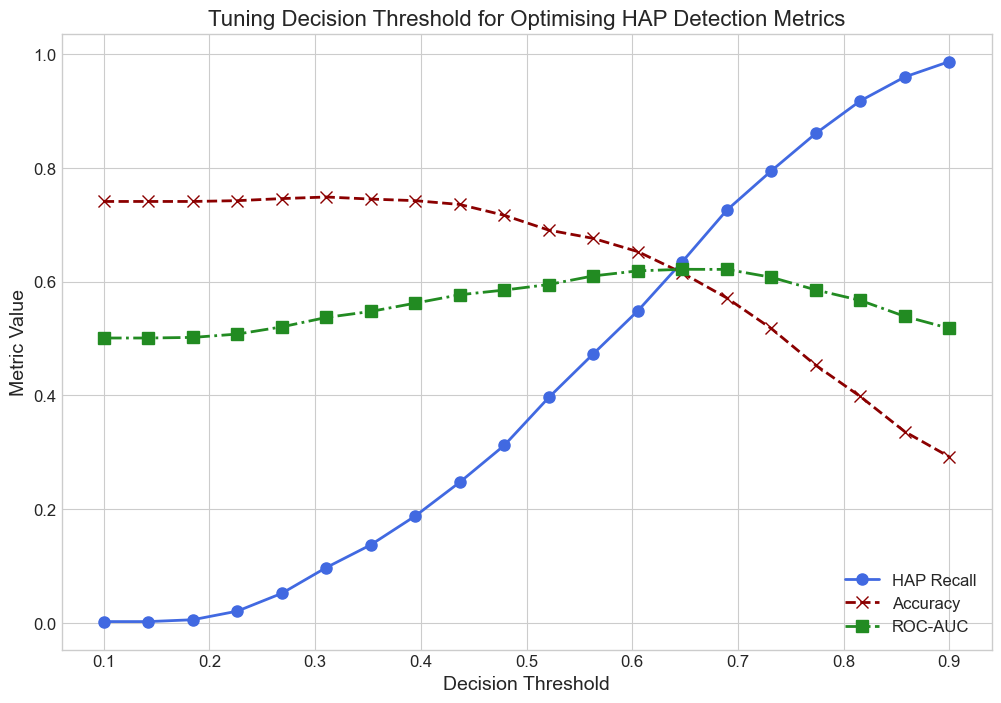

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Initialise data
thresholds = np.linspace(0.1, 0.9, 20)
recalls = []
accuracies = []
roc_aucs = []

# Gather metrics for different thresholds
for THRESHOLD in thresholds:
    y_pred = (model.predict(X_test) > THRESHOLD).astype("int32")
    recall, accuracy, roc_auc = evaluate_model(y_pred, y_test, verbose=False)
    recalls.append(recall)
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc)

# Plot settings
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-whitegrid')

# Plot data
plt.plot(thresholds, recalls, label='HAP Recall', marker='o', linestyle='-', linewidth=2, markersize=8, color='royalblue')
plt.plot(thresholds, accuracies, label='Accuracy', marker='x', linestyle='--', linewidth=2, markersize=8, color='darkred')
plt.plot(thresholds, roc_aucs, label='ROC-AUC', marker='s', linestyle='-.', linewidth=2, markersize=8, color='forestgreen')

# Labels and titles
plt.xlabel('Decision Threshold', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.title('Tuning Decision Threshold for Optimising HAP Detection Metrics', fontsize=16)

# Add grid, legend, and show
plt.grid(True)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


#### Regularisation Experimentation

In [76]:
# Available regularisers
available_regularisers = ['None', 'l1', 'l2', 'l1_l2']

reg_model_params = {'layer_units': [64, 32], 'dropout_rates': [0.3, 0.3], 'activation': 'relu', 'final_activation': 'sigmoid', 
                    'learning_rate': 0.01, 'regulariser': regularisers['l1_l2'], 'clipnorm': 1.0, 'use_batch_norm': True}

reg_training_params = {'early_stopping': early_stopping, 
                       'epochs': 50, 'batch_size': 64, 'sampling_strategy': 'hybridsampling', 'class_weight': None}

sampling_strategy = reg_training_params.get('sampling_strategy')

X_train_sampled = sampling[sampling_strategy]['X_train']
y_train_sampled = sampling[sampling_strategy]['y_train']

In [80]:
regularisers

{'l1': <keras.src.regularizers.L1 at 0x2290f09a370>,
 'l2': <keras.src.regularizers.L2 at 0x228e9722700>,
 'l1_l2': <keras.src.regularizers.L1L2 at 0x228e9722bb0>,
 None: None}

112/112 [==============================] - 0s 722us/step


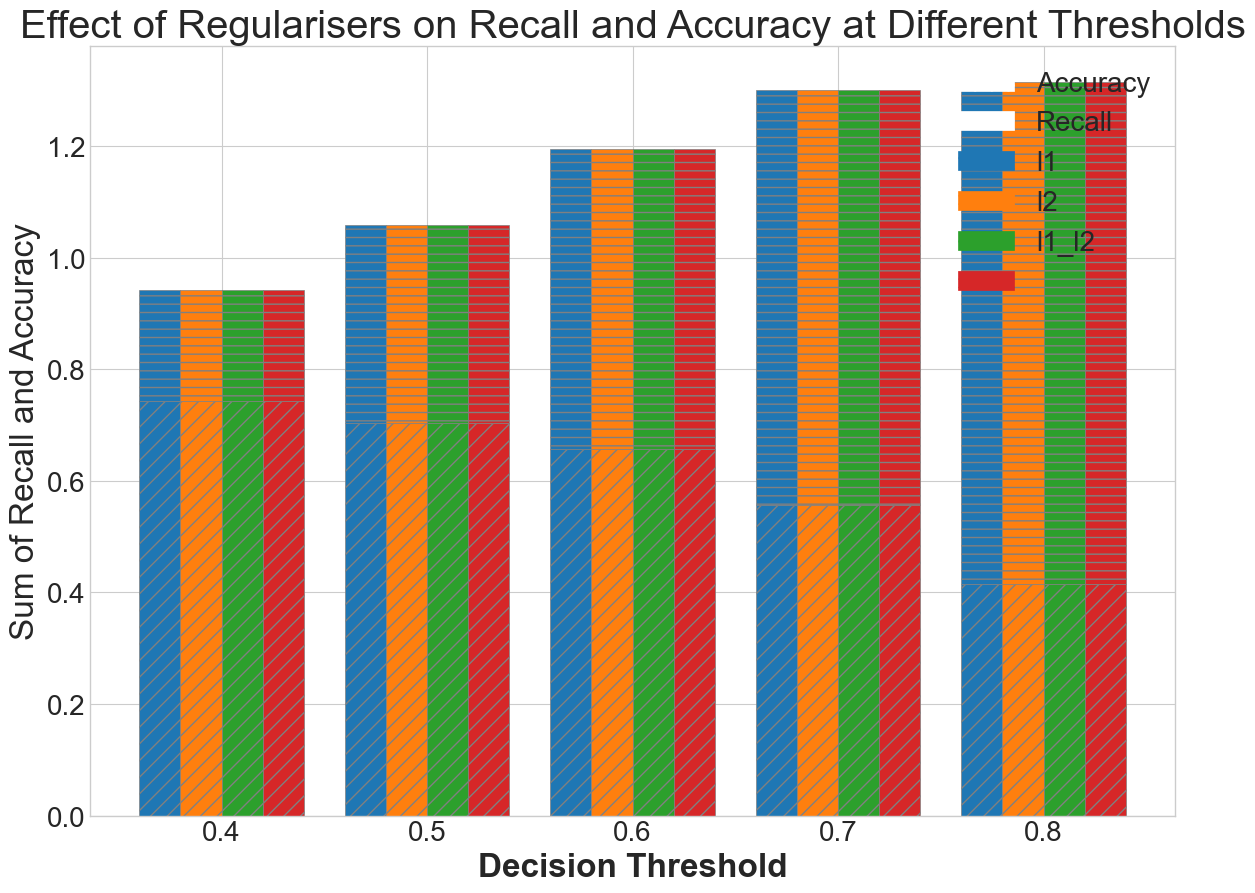

In [90]:
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

selected_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]

# Initialize bar width and positions
barWidth = 0.2
n_thresholds = len(selected_thresholds)
n_regularisers = len(regularisers)
r = np.arange(n_thresholds)

# Initialize figure
plt.figure(figsize=(14, 10))

# Loop through each regulariser
for idx, (reg, colour) in enumerate(zip(regularisers, colours)):
    recalls = []
    accuracies = []
    # Loop through each threshold
    for THRESHOLD in selected_thresholds:
        # Replace this with your actual model training and evaluation code
        # recall = np.random.rand()  # Dummy data
        # accuracy = np.random.rand()  # Dummy data
        y_pred = (model.predict(X_test) > THRESHOLD).astype("int32")
        recall, accuracy, _ = evaluate_model(y_pred, y_test, verbose=False)
        recalls.append(recall)
        accuracies.append(accuracy)

    # Plotting
    plt.bar(r + idx * barWidth, accuracies, color=colour, hatch='//',
            width=barWidth, edgecolor='grey', label=f'{reg} Accuracy' if idx == 0 else "")
    plt.bar(r + idx * barWidth, recalls, bottom=accuracies, color=colour, hatch='--',
            width=barWidth, edgecolor='grey', label=f'{reg} Recall' if idx == 0 else "")

# Adding labels and title
plt.xlabel('Decision Threshold', fontweight='bold')
plt.ylabel('Sum of Recall and Accuracy')
plt.title('Effect of Regularisers on Recall and Accuracy at Different Thresholds')
plt.xticks([r + barWidth * (n_regularisers / 2 - 0.5) for r in range(len(selected_thresholds))], selected_thresholds)

# Add legend
patterns = ['//', '--']
leg_labels = ['Accuracy', 'Recall'] + list(regularisers.keys())

legend_colours = ['white'] * 2 + colours

handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colours[i], hatch=patterns[i % 2]) for i in range(len(leg_labels))]
plt.legend(handles, leg_labels)

# Show plot
plt.show()


In [ ]:
# Lower the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Simplify the architecture (Example)
simpler_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with the new learning rate
simpler_model.compile(optimizer=optimizer,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Adjust the early stopping
adjusted_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
simpler_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[adjusted_early_stopping])


NameError: name 'tf' is not defined

## TODO:

- SMOTE/UnderSampling
- Class Weights
- Cross Validation
- Hyperparameter Tuning

---

- Test features with and without non-predictive features e.g. high temperature
- Separating each HAI
- Ensemble / Boosting
- Separate our feature spaces, predict on each and then do a weighted vote
- Shift focus to Predicting if patient HAS a HAI vs if a patient is at RISK of HAI. Focus on if the patient has ALREADY CONTRACTED HAI
